# Dad's weight project
My dad has been monitoring his weight for about 6 months, but he doesn't plot it, or enter it very nicely.
I have placed his data into ```raw_weight_data_2-2022_8-2022.txt```.

To graph his weight over time, I need to parse the data. It seems there is a consistent trend of putting
```month/day------=weight```. Lets see if we can use python to parse this nicely.

In [7]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

In [8]:
with open('raw_weight_data_2-2022_8-2022.txt') as file:
    data = file.read()
print(data[len(data)-200:])

/ nm / nm / 248.0-3.6=244.4

2/23,wed,12:00, nm / nm / nm / 247.7-3.6=244.1

2/22,tue,12:00, nm / nm / nm / 244.1-3.6=240.5

2/21,mon,11:00, nm / nm / nm / 242.7-3.6=239.1
Ate dinner at mom's place.




In [44]:
pattern = re.compile('^\d/\d{1,2}.+=\d+\.?\d?',re.MULTILINE)
pattern

re.compile(r'^\d/\d{1,2}.+=\d+\.?\d?', re.MULTILINE|re.UNICODE)

In [45]:
matches = pattern.findall(data)
print(matches[0], "\n" ,len(matches))

3/9,wed,12:00, 162 / 88 / 67 / 244.0-3.6=240.4 
 182


In [54]:
dates = []
weights = []
for entry in matches:
    date = entry.split(',')[0]
    if date[-3:] != '/22' or len(date) < 5:
        date += '/22'
    dates.append(date)
    
    weight = entry.split('=')[1]
    weights.append(weight)
    
df = pd.DataFrame(list(zip(dates, weights)), columns=['dates', 'weights'])
df.head()

,dates,weights
0,3/9/22,240.4
1,8/23/22,230.6
2,8/22/22,230.3
3,8/21/22,230.8
4,8/20/22,227.6


In [60]:
df['month'] = df.dates.str.split('/').str[0]
df['day'] = df.dates.str.split('/').str[1]
df.head()

,dates,weights,month,day
0,3/9/22,240.4,3,9
1,8/23/22,230.6,8,23
2,8/22/22,230.3,8,22
3,8/21/22,230.8,8,21
4,8/20/22,227.6,8,20


In [61]:
df = df.sort_values(by =['month', 'day'])
df.head()

,dates,weights,month,day
181,2/21/22,239.1,2,21
180,2/22/22,240.5,2,22
179,2/23/22,244.1,2,23
178,2/25/22,244.4,2,25
177,2/27/22,239.5,2,27


In [62]:
# df.to_csv("parsed_dad_weights.csv", index=False, header=True)

## Now we can plot it

In [2]:
df = pd.read_csv('parsed_dad_weights.csv')
df['weights'] = df.weights.astype(float)
df = df.loc[df.weights > 100,]
print(df.shape)
df.head()

(179, 4)


,dates,weights,month,day
0,2/21/22,239.1,2,21
1,2/22/22,240.5,2,22
2,2/23/22,244.1,2,23
3,2/25/22,244.4,2,25
4,2/27/22,239.5,2,27


In [3]:
dates_to_label = df.loc[[0,floor(df.shape[0]/4), 2*floor(df.shape[0]/4), 3*floor(df.shape[0]/4), df.shape[0]],]

([<matplotlib.axis.XTick at 0x1c5d87fc100>,
 [Text(0, 0, '2/21/22'),
  Text(44, 0, '4/19/22'),
  Text(88, 0, '5/26/22'),
  Text(132, 0, '7/15/22'),
  Text(179, 0, '8/7/22')])

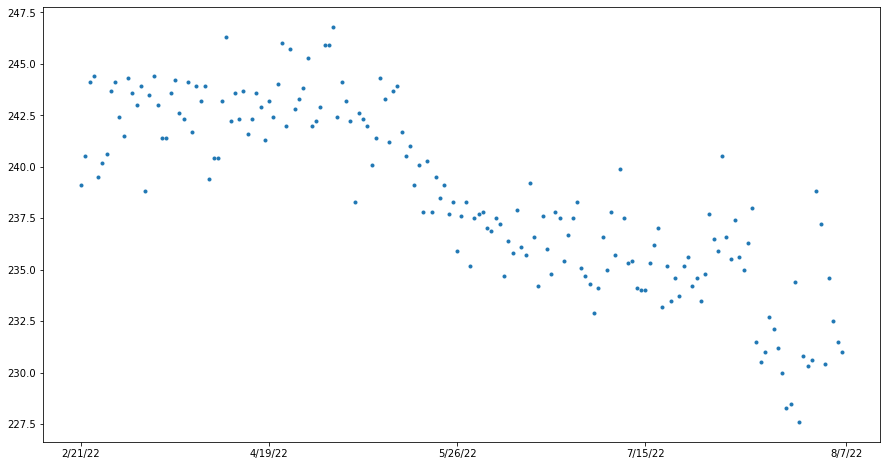

In [4]:
plt.figure(figsize=(15, 8))
plt.plot(range(0,df.shape[0]), df['weights'], linewidth=0, marker='.')
plt.xticks(ticks=dates_to_label.index,
          labels=dates_to_label['dates'],)

{'whiskers': [<matplotlib.lines.Line2D at 0x7faa6610d940>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa6610dd60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa65ede6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa66104a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa661043d0>],
 'means': []}

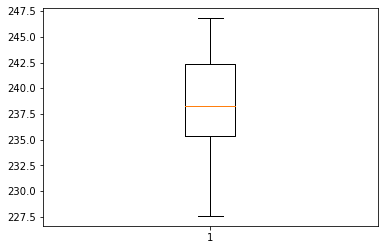

In [90]:
plt.boxplot(df['weights'])

In [92]:
df['weights'].describe()

count    179.000000
mean     238.608939
std        4.342982
min      227.600000
25%      235.350000
50%      238.300000
75%      242.400000
max      246.800000
Name: weights, dtype: float64

## Rolling average values for timecourse 1st attempt
**Pseudocode:** 
1. Start a window at position 0 of size n.
2. Compute the average within this window and store it
3. Move over one value
4. Repeat until we reach len(data)-n

In [39]:
rollingAverage = []
rollingStd = []
rawData = df['weights']
n = 5
for i in range(len(df['weights'])-n):
    windowStart = i
    windowEnd = i+n
    rollingAverage.append(np.mean(rawData[windowStart:windowEnd]))
    rollingStd.append(np.std(rawData[windowStart:windowEnd]))
#rollingAverage.extend(4*[rollingAverage[-1]])

## Rolling average values for timecourse 2nd attempt
I would like to have my point in the middle of the pack, not on the end. 
I would also like to get a value for every position.

**Pseudocode:** 
1. Start a window at position 0 of size n*2+1.
2. The windowStart = max(0,currentPos-n)
3. The windowEnd = min(len(data), currentPos+n)
2. Compute the average within this window and store it
3. Move over one value
4. Repeat until we reach len(data)

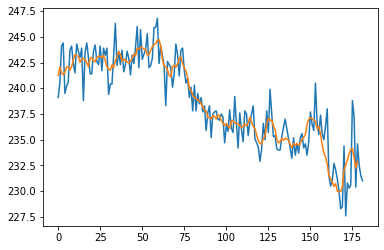

In [63]:
rollingAverage = []
rawData = df['weights']
n = 3
for i in range(len(rawData)):
    windowStart = np.maximum(0,i-n)
    windowEnd = np.minimum(len(rawData)-1,i+n)
    rollingAverage.append(np.mean(rawData[windowStart:windowEnd]))
    
plt.plot(rawData)
plt.plot(rollingAverage)
#rollingAverage.extend(4*[rollingAverage[-1]])

## Turning it into a function

In [64]:
def rollingFun(data, windowSize, fun=np.mean):
    rollingAverage = []
    data = np.array(data)
    for i in range(len(data)):
        windowStart = np.maximum(0,i-windowSize)
        windowEnd = np.minimum(len(data)-1,i+windowSize)
        rollingAverage.append(fun(data[windowStart:windowEnd]))
    return(rollingAverage)

Text(0.5, 1.0, 'The points deviate from the average by 1.965 pounds')

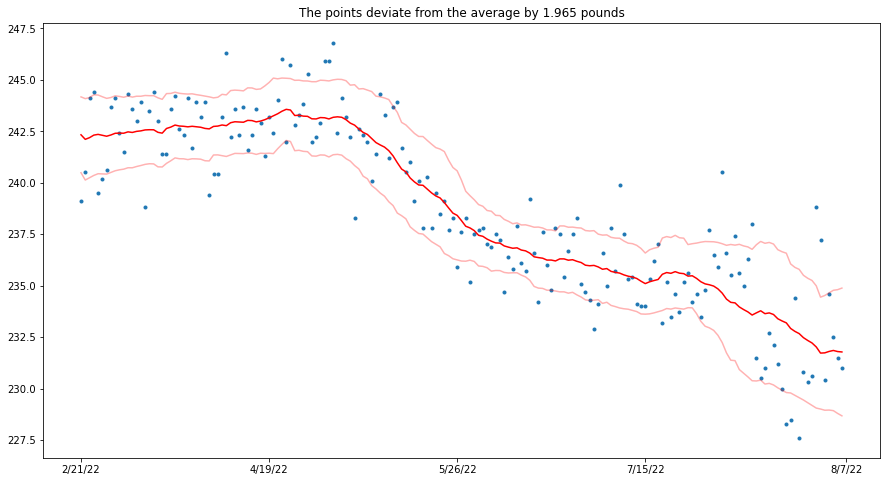

In [103]:
rollingAverage = rollingFun(df['weights'], 15, np.mean)
rollingStd = rollingFun(df['weights'], 15, np.std)

plt.figure(figsize=(15, 8))
plt.plot(range(0,df.shape[0]), df['weights'], linewidth=0, marker='.')
plt.xticks(ticks=dates_to_label.index,
          labels=dates_to_label['dates'],)

plt.plot(rollingAverage, color='red')
plt.plot(np.array(rollingAverage) + np.array(rollingStd), color=[1,0,0], alpha=0.3)
plt.plot(np.array(rollingAverage) - np.array(rollingStd), color=[1,0,0], alpha=0.3)
plt.title(f"The points deviate from the average by {round(np.mean(rollingStd),3)} pounds")

## Finding the weights rate of change

We will be using some techniques from https://www.youtube.com/watch?v=DeeoiE22bZ8&t=443s Mr. Problem Solver's Youtube channel, and take the derivative of our `rollingAverage` metric using `np.gradient` numpy function.

If we want to know what `np.gradient` is doing, we can google "np.gradient documentation" and the first link for me was https://numpy.org/doc/stable/reference/generated/numpy.gradient.html. The content of the documentation is a bit verbose, and discusses math approximations I don't understand. 

Luckily the second link that shows up gives me a Stack Overflow answer to my exact question: https://stackoverflow.com/questions/24633618/what-does-numpy-gradient-do. For these values `[3,6,7]` It seems like our `np.gradient` function does can compute the slope of the middle value as $(7-3)/2 = 2$ and for the two boundries $6-3 = 3$ and $7-6 = 1$. The resulting gradient should be `[3,2,1]`

In [79]:
print('Tada!!!')
np.gradient([3,6,7])

Tada!!!


array([3., 2., 1.])

So let compute the rate of change of my dads weight to see how quickly he is loosing weight. Unfortunately the "smoothing" still produces a noisy derivative, I would probably need a spline function of some sort to produce a smoother derivative. But for now, to put a bandaid on the problem, I'll also smooth the derivative!

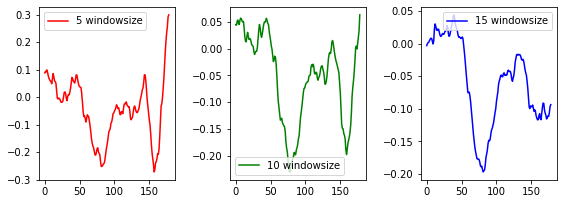

In [109]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
windowSizes = [5,10,15]
plotCol = ['r', 'g', 'b']

for i in range(3):
    rollingAverage = rollingFun(df['weights'], windowSizes[i], np.mean)
    drolldt = np.gradient(rollingAverage)
    ax[i].plot(rollingFun(drolldt, 10), label=f'{windowSizes[i]} windowsize', color=plotCol[i])# rollingFun(drolldt, 10)
[a.legend() for a in ax]

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

I like a windowsize of 15 for the most.

From this first derivative I can clearly see that dramatic increase of weight loss for about 50 days, then over the course of a month, we stop seeing such a large loss, and now we see the weight loss trend leveling off to a consistent rate.

In [ ]:
Now I am curous about the second derivative of my dads weight loss. This would show me how he accelerates his weight loss.

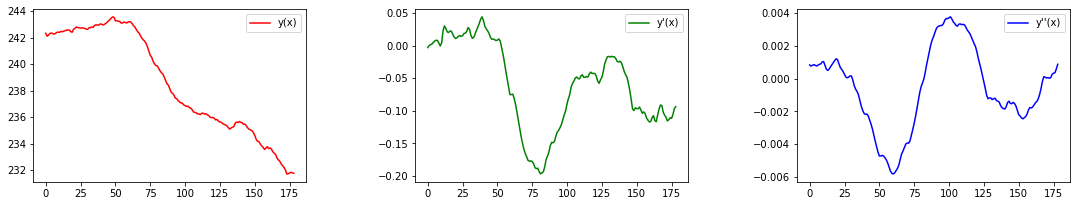

In [123]:
rollingAverage = rollingFun(df['weights'], 15)
drolldt = rollingFun(np.gradient(rollingAverage), 10)
droll2dt = rollingFun(np.gradient(drolldt), 20)

fig,ax = plt.subplots(1,3, figsize=(18,3))
ax[0].plot(rollingAverage, color='red', label="y(x)")
ax[1].plot(drolldt, color='green', label="y'(x)")
ax[2].plot(droll2dt, color='blue', label="y''(x)")
[a.legend(loc='upper right') for a in ax]

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()